# Applied Network Science extension

### Import libraries

In [170]:
import skfda
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.colors as pltcol
import os
from scipy.cluster.hierarchy import dendrogram, linkage, set_link_color_palette
from scipy.spatial.distance import squareform
from sklearn import preprocessing
import statsmodels.api as sm
import statsmodels.formula.api as smf
import itertools
import time
from sklearn.linear_model import ElasticNetCV, enet_path


### Methods and plot settings

In [171]:
def extract_window(time_window):
    data_aligned=pd.DataFrame()
    for col in data.columns:
        first_inv_year=data.loc[~data[col].isna(), col].index[0]
        if first_inv_year>1999 and first_inv_year<2021-time_window:
            x=data.loc[first_inv_year:,col].reset_index()
            data_aligned[col]=x[col]
    data_aligned=data_aligned.fillna(0)
    data_aligned=data_aligned.cumsum()
    data_export=data_aligned.loc[0:time_window-1,:]
    return data_export

# We run K-means 100 times per sector in order to "be sure" of clustering partitions
def functional_clustering(data):
    clusters={}
    kmeans=skfda.ml.clustering.KMeans(n_clusters=2, n_init=100)
    for sector in content.industry.unique():
        idx=content[content.industry==sector].id_x
        mat=data.loc[:,data.columns.isin(idx)]
        if mat.shape[1]>1:
            fdmat = skfda.FDataGrid(mat.transpose().to_numpy())
            labels=kmeans.fit_predict(fdmat)
            if kmeans.cluster_centers_.evaluate(0.5)[1]>kmeans.cluster_centers_.evaluate(0.5)[0]:
                for x in zip(mat.columns, labels):
                    clusters[x[0]]=x[1]
            else:
                for x in zip(mat.columns, labels):
                    clusters[x[0]]= 0 if x[1]==1 else 1
    return clusters

In [ ]:
colors = [plt.cm.Set3(i) for i in range(20)]
high_regime=colors[0]
low_regime=colors[3]
default_color=colors[4]
default_color2=low_regime
default_color3=high_regime
default_color4=colors[5]
plt.cm.get_cmap('Set3')

### Data preprocessing

In [172]:
cb1 = pd.read_csv('cb1.csv')
cb2 = pd.read_csv('cb2.csv')
cb3 = pd.read_csv('cb3.csv')
cb = cb1.append(cb2)
cb = cb.append(cb3)
cb.index = range(len(cb))
cb['date_my'] = (pd.to_datetime(cb['date'],format='%m/%d/%Y', errors='coerce')).dt.to_period('m')
cb['date_y'] = (pd.to_datetime(cb['date'],format='%m/%d/%Y', errors='coerce')).dt.to_period('y')

nodes_org = cb[['target_name', 'target_ID']].drop_duplicates()
nodes_org['bipartite'] = 1
nodes_inv = cb[['investors_name', 'investor_id']].drop_duplicates()
nodes_org = nodes_org.rename(columns={"target_name": "node", "target_country": "country", 
                                      "target_continent": "continent", "industry":"industry",
                                     "target_ID":"index"})
nodes_inv = nodes_inv.rename(columns={"investors_name": "node","investor_country": "country", 
                                      "investor_continent": "continent", "investor_type":"industry","investor_id":'index' })
nodes_inv['bipartite'] = 0
nodes = nodes_org.append(nodes_inv, ignore_index= True)
nodes['id'] = nodes.index

numbers = cb.groupby(['target_name','stage'], as_index = False).count()[['target_name','stage','investors_name']].rename(columns={"investors_name": "investor_numbers"})
cb_new = pd.merge(cb, numbers,  how='left', left_on=['target_name','stage'], right_on = ['target_name','stage'])
cb_new = pd.merge(cb_new, nodes[nodes['bipartite']== 1],  how='left', left_on=['target_name','target_ID'], right_on = ['node','index'])
cb_new = pd.merge(cb_new, nodes[nodes['bipartite']== 0],  how='left', left_on=['investors_name','investor_id'], right_on = ['node','index'])

data=cb_new[['target_name', 'industry', 'id_x', 'date_y', 'size_real', 'target_founded', 'target_status', 'round_simp']]
data.date_y=data.date_y.dt.year
a=data.groupby(['round_simp']).count()
a['target_name']=a.target_name/data.shape[0]
remove=['Asset Sale', 'Bridge', 'Dead', 'Debt', 'Distressed & Special Situation', 'Leveraged Buyout', 'Line of Credit', 
 'Loan', 'Management Buyout', 'Milestone Payment', 'Other Investors', 'Portfolio Merger', 'Portfolio NewCo',
 'Secondary Market', 'Shareholder Liquidity']

data=data[data.size_real>0]
#data=data[~data.target_founded.isna()]
data=data[data.date_y<2021]
data=data.loc[data.industry.isna()==False,]
data=data.loc[~data.round_simp.isin(remove)]

content=data[['industry','id_x', 'target_name', 'target_founded', 'target_status']].drop_duplicates()
content['alive']=np.where(content.target_status.isin(['Alive / Active']),1,0)

data=data.groupby(['id_x','target_name','date_y']).mean().reset_index()
data=data.pivot('date_y','id_x','size_real')

 c:\python38\lib\site-packages\pandas\core\generic.py:5516: SettingWithCopyWarning:
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [155]:
data3=extract_window(3)
data3.to_csv('money_three.csv', index = False)

 C:\Users\Public\Documents\Wondershare\CreatorTemp\ipykernel_20976\1640326975.py:7: PerformanceWarning:DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`


In [ ]:
content.head()

In [ ]:
content.industry.value_counts()

### Processing

#### Window analysis

In [144]:
percentage=[]
for size in range(5,13):
    data_size=extract_window(size)
    clusters=functional_clustering(data_size)
    percentage.append(sum(clusters.values())/len(clusters.values()))

 C:\Users\Public\Documents\Wondershare\CreatorTemp\ipykernel_20976\1640326975.py:7: PerformanceWarning:DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`


In [145]:
win_big=[]
for size in range(5,13):
    data_size=extract_window(size)
    win_big.append(data_size.shape[1])

 C:\Users\Public\Documents\Wondershare\CreatorTemp\ipykernel_20976\1640326975.py:7: PerformanceWarning:DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`


Text(0, 0.5, 'Fraction of successful firms')

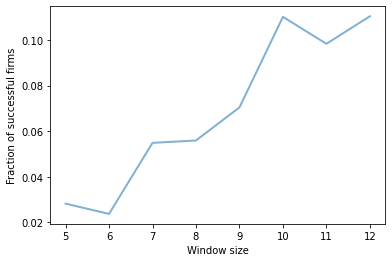

In [146]:
fig, ax = plt.subplots(1,1, figsize=(6, 4))
plt.plot(range(5,13), percentage, c=default_color, linewidth=2)
plt.xlabel('Window size')
plt.ylabel('Fraction of successful firms')
#plt.title('Fraction of high-regime firms by window size')

#os.chdir('/Users/ltesta/Documents/GitHub/crunch_net/ANS/plots')
#plt.savefig('fraction_high_regime.pdf', bbox_inches="tight")

Text(0, 0.5, 'Number of firms')

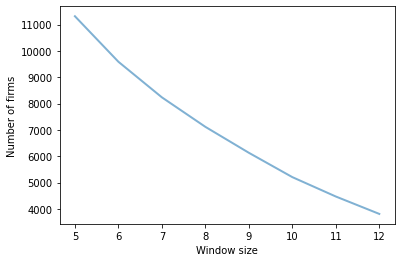

In [147]:
fig, ax = plt.subplots(1,1, figsize=(6, 4))
plt.plot(range(5,13), win_big, c=default_color, linewidth=2)
plt.xlabel('Window size')
plt.ylabel('Number of firms')
#plt.title('Number of firms by window size')

#os.chdir('/Users/ltesta/Documents/GitHub/crunch_net/ANS/plots')
#plt.savefig('number_firms_window_size.pdf', bbox_inches="tight")

In [173]:
size=8
data_size=extract_window(size)
#data_size=data_size.apply(np.log)

 C:\Users\Public\Documents\Wondershare\CreatorTemp\ipykernel_20976\1640326975.py:7: PerformanceWarning:DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`


In [149]:
data_size.head()

,15,17,19,23,24,26,27,32,34,36,...,18800,18801,18803,18804,18805,18807,18815,18816,18820,18823
0,8.402846e+06,2.172304e+07,1.543503e+07,7.560706e+06,8.065279e+06,5.965489e+06,2.212317e+08,6.805763e+06,3.910406e+07,1.979740e+05,...,497705.658223,3.555040e+06,8.887601e+05,4.811155e+07,189602.155514,1.386466e+06,6.636075e+05,118501.347196,1.078362e+06,9.800061e+06
1,8.402846e+06,2.172304e+07,1.543503e+07,1.947403e+07,8.065279e+06,1.971183e+07,2.212317e+08,6.805763e+06,3.910406e+07,3.916830e+05,...,497705.658223,3.555040e+06,8.887601e+05,4.811155e+07,189602.155514,1.386466e+06,6.636075e+05,118501.347196,1.078362e+06,9.800061e+06
2,8.402846e+06,6.267970e+07,1.543503e+07,1.947403e+07,8.065279e+06,1.971183e+07,2.212317e+08,1.469913e+07,3.910406e+07,1.027576e+06,...,497705.658223,7.048631e+06,1.249764e+06,4.811155e+07,189602.155514,1.386466e+06,2.911523e+06,118501.347196,1.078362e+06,9.800061e+06
3,8.402846e+06,1.019741e+08,1.543503e+07,1.947403e+07,8.065279e+06,1.971183e+07,2.212317e+08,1.469913e+07,3.910406e+07,1.027576e+06,...,497705.658223,7.048631e+06,1.249764e+06,4.811155e+07,189602.155514,1.386466e+06,9.818099e+06,118501.347196,1.078362e+06,9.800061e+06
4,8.402846e+06,1.019741e+08,1.543503e+07,1.947403e+07,8.065279e+06,5.960066e+07,2.212317e+08,1.469913e+07,3.910406e+07,1.027576e+06,...,497705.658223,7.048631e+06,1.249764e+06,4.811155e+07,408268.150137,1.386466e+06,9.818099e+06,118501.347196,1.078362e+06,9.800061e+06


In [ ]:
clusters=functional_clustering(data_size)

In [ ]:
print('Percentage of successful firms:', 100*sum(clusters.values())/len(clusters.values()), '%')

Text(0, 0.5, 'Cumulative money raised')

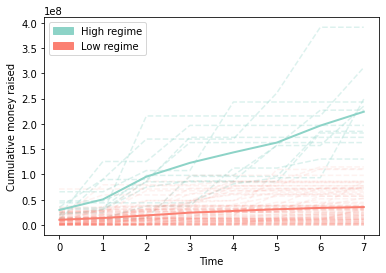

In [174]:
toplot=data_size.loc[:, data_size.columns.isin(content[content.industry=='Drug Discovery'].id_x)]
toplot1=toplot.loc[:, toplot.columns.isin([x for x in clusters.keys() if clusters[x]==1])]
toplot0=toplot.loc[:, toplot.columns.isin([x for x in clusters.keys() if clusters[x]==0])]

fig, ax = plt.subplots(1,1, figsize=(6, 4))
plt.plot(toplot1, c=high_regime, alpha=0.3, linestyle='--')
plt.plot(toplot0, c=low_regime, alpha=0.1, linestyle='--')
plt.plot(range(0,size), np.mean(toplot1, axis=1), c=high_regime, linewidth=2)
plt.plot(range(0,size), np.mean(toplot0, axis=1), c=low_regime, linewidth=2)
high_patch = mpatches.Patch(color=high_regime, label='High regime')
low_patch = mpatches.Patch(color=low_regime, label='Low regime')
plt.legend(handles=[high_patch, low_patch])
plt.xlabel('Time')
plt.xticks(range(0,size))
plt.ylabel('Cumulative money raised')
#plt.title('Trajectories in Drug Discovery sector by cluster')

#os.chdir('/Users/ltesta/Documents/GitHub/crunch_net/ANS/plots')
#plt.savefig('drug_discovery_clustering_'+str(size)+'.pdf', bbox_inches="tight")

#### Covariates preparation

In [192]:
#os.chdir('/Users/ltesta/Documents/GitHub/crunch_net/ANS/ANS_all')
covariates=pd.read_csv('covariates.csv')
covariates=covariates.drop(['voterank_max', 'voterank_min', 'voterank_median', 'voterank_org'], axis=1)

In [193]:
covariates.head()

,Unnamed: 0,node,country,continent,industry,bipartite,id,deg_max,deg_min,deg_median,...,num_inv,deg_org,clustering_org,core_number_org,harmonic_centrality_org,closeness_centrality_org,newman_betweenness_centrality_org,pagerank_org,eigenvector_centrality_org,average_neighbor_degree_org
0,15,NeuroMolecular Pharmaceuticals,United States,North America,Pharmaceuticals / Drugs,1,15,32.0,32.0,32.0,...,1,7.0,1.000000,7.0,1033.095238,0.281749,0.000000,0.000093,0.000112,33.571429
1,17,AngioScore,United States,North America,Medical Devices & Equipment,1,17,47.0,10.0,14.0,...,5,29.0,0.263547,21.0,983.878571,0.330985,0.000659,0.000282,0.002502,69.000000
2,19,Prematics,United States,North America,Healthcare Software,1,19,18.0,4.0,10.5,...,4,10.0,0.311111,8.0,1467.222619,0.284009,0.000042,0.000083,0.000077,33.800000
3,23,GlobeImmune,United States,North America,Drug Development,1,23,21.0,4.0,12.5,...,2,4.0,1.000000,4.0,536.669048,0.246216,0.000000,0.000220,0.000048,13.750000
4,24,Axium Healthcare Pharmacy,United States,North America,Medical Facilities & Services,1,24,3.0,3.0,3.0,...,1,2.0,1.000000,2.0,1016.290476,0.244604,0.000000,0.000065,0.000004,10.000000


array([[<AxesSubplot:title={'center':'Unnamed: 0'}>,
        <AxesSubplot:title={'center':'bipartite'}>,
        <AxesSubplot:title={'center':'id'}>,
        <AxesSubplot:title={'center':'deg_max'}>,
        <AxesSubplot:title={'center':'deg_min'}>,
        <AxesSubplot:title={'center':'deg_median'}>],
       [<AxesSubplot:title={'center':'clustering_max'}>,
        <AxesSubplot:title={'center':'clustering_min'}>,
        <AxesSubplot:title={'center':'clustering_median'}>,
        <AxesSubplot:title={'center':'harmonic_centrality_max'}>,
        <AxesSubplot:title={'center':'harmonic_centrality_min'}>,
        <AxesSubplot:title={'center':'harmonic_centrality_median'}>],
       [<AxesSubplot:title={'center':'closeness_centrality_max'}>,
        <AxesSubplot:title={'center':'closeness_centrality_min'}>,
        <AxesSubplot:title={'center':'closeness_centrality_median'}>,
        <AxesSubplot:title={'center':'newman_betweenness_centrality_max'}>,
        <AxesSubplot:title={'center':'ne

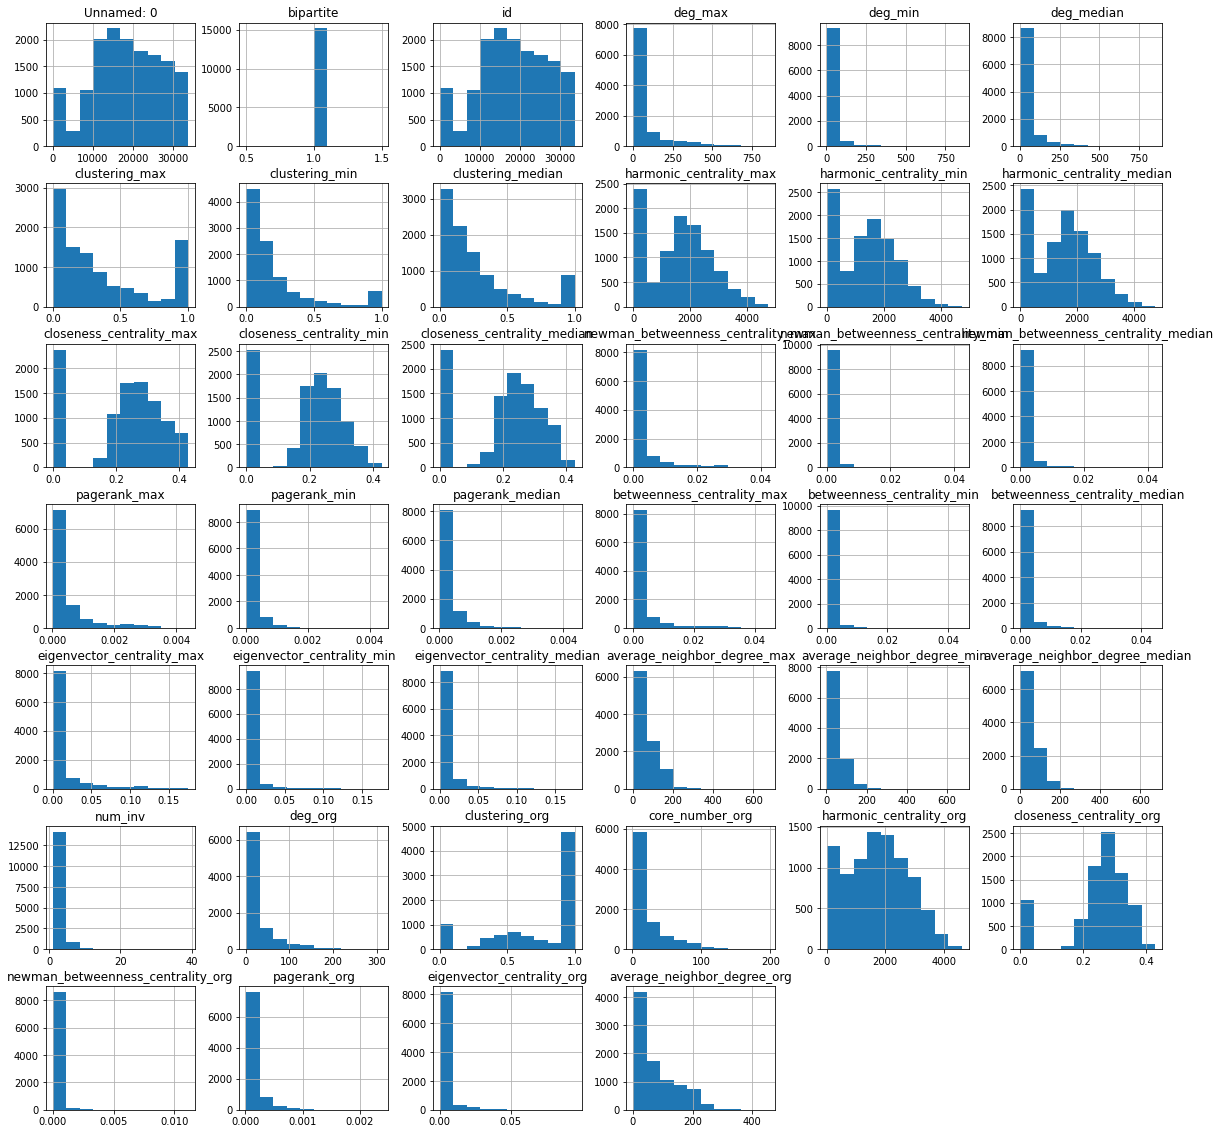

In [194]:
covariates.hist(figsize=(20,20))
#os.chdir('/Users/ltesta/Documents/GitHub/crunch_net/ANS/plots')
#plt.savefig('covariates_distribution.pdf', bbox_inches="tight")

In [195]:
# Transformations (plotted and chosen individually)
covariates['deg_max']=np.log(covariates['deg_max'])
covariates['deg_min']=np.log(covariates['deg_min'])
covariates['deg_median']=np.log(covariates['deg_median'])
covariates['newman_betweenness_centrality_max']=np.log(covariates['newman_betweenness_centrality_max']+0.001)
covariates['newman_betweenness_centrality_min']=np.log(covariates['newman_betweenness_centrality_min']+0.001)
covariates['newman_betweenness_centrality_median']=np.log(covariates['newman_betweenness_centrality_median']+0.001)
covariates['pagerank_max']=np.log(covariates['pagerank_max'])
covariates['pagerank_min']=np.log(covariates['pagerank_min'])
covariates['pagerank_median']=np.log(covariates['pagerank_median'])
covariates['betweenness_centrality_max']=np.log(covariates['betweenness_centrality_max']+0.001)
covariates['betweenness_centrality_min']=np.log(covariates['betweenness_centrality_min']+0.001)
covariates['betweenness_centrality_median']=np.log(covariates['betweenness_centrality_median']+0.001)
covariates['average_neighbor_degree_max']=np.log(covariates['average_neighbor_degree_max'])
covariates['average_neighbor_degree_min']=np.log(covariates['average_neighbor_degree_min'])
covariates['average_neighbor_degree_median']=np.log(covariates['average_neighbor_degree_median'])

covariates['num_inv']=np.log(covariates['num_inv'])

covariates['deg_org']=np.log(covariates['deg_org'])
covariates['core_number_org']=np.log(covariates['core_number_org'])
covariates['newman_betweenness_centrality_org']=np.log(covariates['newman_betweenness_centrality_org']+0.0001)
covariates['pagerank_org']=np.log(covariates['pagerank_org'])

(array([8143.,  322.,  187.,   86.,   43.,   17.,   14.,    0.,    0.,
          14.]),
 array([0.        , 0.00908292, 0.01816584, 0.02724876, 0.03633168,
        0.0454146 , 0.05449752, 0.06358044, 0.07266336, 0.08174628,
        0.0908292 ]),
 <BarContainer object of 10 artists>)

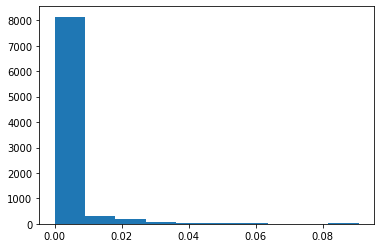

In [196]:
plt.hist(np.log(covariates['eigenvector_centrality_org'] +1))

In [ ]:
covariates.columns

In [ ]:
covariates.hist(figsize=(20,20))
#os.chdir('/Users/ltesta/Documents/GitHub/crunch_net/ANS/plots')
#plt.savefig('covariates_distribution_after_log.pdf', bbox_inches="tight")

In [197]:
Z=covariates.drop(['node','country','continent','industry','bipartite','id'], axis=1)

Z=Z.dropna()

scaler = preprocessing.StandardScaler().fit(Z)
Z_scaled = scaler.transform(Z)
Z_scaled=pd.DataFrame(Z_scaled)
Z_scaled.columns=Z.columns
Z_scaled.shape

(8455, 38)

In [ ]:
Z_scaled.corr().reset_index()#.iloc[14,:]

In [ ]:
link = linkage(squareform(Z_scaled.corr().apply(lambda x: 1- np.abs(x))), method='complete')
fig = plt.figure(figsize=(10, 8))
set_link_color_palette([pltcol.rgb2hex(colors[0]), pltcol.rgb2hex(colors[2]), pltcol.rgb2hex(colors[3]), pltcol.rgb2hex(colors[5]), pltcol.rgb2hex(colors[6]), pltcol.rgb2hex(colors[9])])
dn=dendrogram(link, labels=Z.columns, leaf_rotation=0, above_threshold_color=pltcol.rgb2hex(default_color), orientation='left')
#plt.title('Feature dendrogram')
#os.chdir('/Users/ltesta/Documents/GitHub/crunch_net/ANS/plots')
#plt.savefig('dendrogram.pdf', bbox_inches="tight")


Chosen covariates REDO
- aaa
- clustering_median
- newman_betweenness_centrality_org
- harmonic_centrality_max
- pagerank_min

#### Logistic regression

In [72]:
clusters=functional_clustering(data_size)

In [ ]:
binary=pd.DataFrame(clusters.keys(), clusters.values()).reset_index()
binary.columns=['cluster', 'idx']
binary['idx']=binary.idx.apply(float)

In [ ]:
binary_merge=pd.merge(binary, covariates, left_on='idx', right_on='id')
binary_merge.index=binary_merge.idx
binary_merge=binary_merge.drop(['node', 'id', 'bipartite', 'idx'], axis=1)
binary_merge['num_inv']=binary_merge.num_inv.apply(float)
cat=binary_merge.select_dtypes(exclude=['float64'])
num=binary_merge.select_dtypes(include=['float64'])

scaler = preprocessing.StandardScaler().fit(num)
num_scaled = scaler.transform(num)
num_scaled=pd.DataFrame(num_scaled)
num_scaled.columns=num.columns
num_scaled.index=cat.index

binary_merge=pd.concat([cat, num_scaled], axis=1)

In [ ]:
results = smf.logit('cluster ~ clustering_median + newman_betweenness_centrality_org + harmonic_centrality_max + pagerank_min', data=binary_merge).fit()
print(results.summary())

In [ ]:
pseudor=[]
pvalues=[]
coef=[]
for i in range(1000):
    pos=binary_merge[binary_merge.cluster==1]
    neg=binary_merge[binary_merge.cluster==0].sample(pos.shape[0])
    balanced=pd.concat([pos,neg])
    results = smf.logit('cluster ~ clustering_median + newman_betweenness_centrality_org + harmonic_centrality_max + pagerank_min', data=balanced).fit()
    pseudor.append(results.prsquared)
    pvalues.append(results.pvalues)
    coef.append(results.params)

In [ ]:
significance=[x.apply(lambda x: -np.log(x)) for x in pvalues]

fig, axs = plt.subplots(2, 3, figsize=(15, 10))
axs[0, 0].plot([x[0] for x in coef], [x[0] for x in significance], '.', c=default_color)
axs[0, 0].axvline(np.mean([x[0] for x in coef]), c=default_color2)
axs[0, 0].axvline(np.mean([x[0] for x in coef])-np.std([x[0] for x in coef]), linestyle='--', c=default_color2)
axs[0, 0].axvline(np.mean([x[0] for x in coef])+np.std([x[0] for x in coef]), linestyle='--', c=default_color2)
axs[0, 0].set_title(significance[0].index[0])
axs[0, 1].plot([x[1] for x in coef], [x[1] for x in significance], '.', c=default_color)
axs[0, 1].axvline(np.mean([x[1] for x in coef]), c=default_color2)
axs[0, 1].axvline(np.mean([x[1] for x in coef])-np.std([x[1] for x in coef]), linestyle='--', c=default_color2)
axs[0, 1].axvline(np.mean([x[1] for x in coef])+np.std([x[1] for x in coef]), linestyle='--', c=default_color2)
axs[0, 1].set_title(significance[0].index[1])
axs[0, 2].plot([x[2] for x in coef], [x[2] for x in significance], '.', c=default_color)
axs[0, 2].axvline(np.mean([x[2] for x in coef]), c=default_color2)
axs[0, 2].axvline(np.mean([x[2] for x in coef])-np.std([x[2] for x in coef]), linestyle='--', c=default_color2)
axs[0, 2].axvline(np.mean([x[2] for x in coef])+np.std([x[2] for x in coef]), linestyle='--', c=default_color2)
axs[0, 2].set_title(significance[0].index[2])
axs[1, 0].plot([x[3] for x in coef], [x[3] for x in significance], '.', c=default_color)
axs[1, 0].axvline(np.mean([x[3] for x in coef]), c=default_color2)
axs[1, 0].axvline(np.mean([x[3] for x in coef])-np.std([x[3] for x in coef]), linestyle='--', c=default_color2)
axs[1, 0].axvline(np.mean([x[3] for x in coef])+np.std([x[3] for x in coef]), linestyle='--', c=default_color2)
axs[1, 0].set_title(significance[0].index[3])
axs[1, 1].plot([x[4] for x in coef], [x[4] for x in significance], '.', c=default_color)
axs[1, 1].axvline(np.mean([x[4] for x in coef]), c=default_color2)
axs[1, 1].axvline(np.mean([x[4] for x in coef])-np.std([x[4] for x in coef]), linestyle='--', c=default_color2)
axs[1, 1].axvline(np.mean([x[4] for x in coef])+np.std([x[4] for x in coef]), linestyle='--', c=default_color2)
axs[1, 1].set_title(significance[0].index[4])
axs[1, 2].set_visible(False)

for ax in axs.flat:
    ax.set(xlabel='Coefficient estimate', ylabel='Significance')
for ax in axs.flat:
    ax.axhline(-np.log(0.1),color=default_color3,ls='--')
    ax.axvline(0, c=default_color3)

#os.chdir('/Users/ltesta/Documents/GitHub/crunch_net/ANS/plots')
#plt.savefig('significance_logistic.pdf', bbox_inches="tight")

np.mean(pseudor)


#### Linear regression

In [198]:
cumulate=data_size.loc[data_size.shape[0]-1,:]

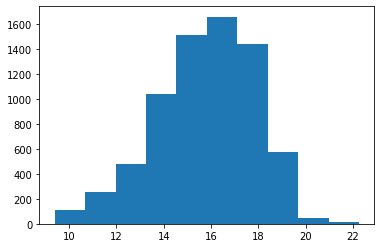

In [199]:
plt.hist(np.log(cumulate))
plt.show()

In [200]:
cumulate=pd.DataFrame(cumulate).reset_index()
cumulate.columns=['idx', 'cum']

In [201]:
cumulate['cum']=cumulate.cum.apply(np.log)
covariates['id']=covariates.id.apply(float)

In [209]:
cumulative_merge=pd.merge(cumulate, covariates, left_on='idx', right_on='id')
cumulative_merge.index=cumulative_merge.idx
cumulative_merge['first'] = data_size.loc[0,]
cumulative_merge['first'] = cumulative_merge['first'].apply(np.log)
cumulative_merge=cumulative_merge.drop(['node', 'id', 'bipartite', 'idx'], axis=1)

cat=cumulative_merge.select_dtypes(exclude=['float64', 'int64'])
num=cumulative_merge.select_dtypes(include=['float64', 'int64'])

scaler = preprocessing.StandardScaler().fit(num)
num_scaled = scaler.transform(num)
num_scaled=pd.DataFrame(num_scaled)
num_scaled.columns=num.columns
num_scaled.index=cat.index

cumulative_merge=pd.concat([cat, num_scaled], axis=1)

In [213]:
results = smf.ols('cum - first ~ clustering_median + newman_betweenness_centrality_org + harmonic_centrality_max + pagerank_min + industry + continent ', data=cumulative_merge).fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                    cum   R-squared:                       0.214
Model:                            OLS   Adj. R-squared:                  0.209
Method:                 Least Squares   F-statistic:                     38.94
Date:                Sun, 23 Jan 2022   Prob (F-statistic):          1.08e-198
Time:                        14:01:56   Log-Likelihood:                -5354.5
No. Observations:                4320   AIC:                         1.077e+04
Df Residuals:                    4289   BIC:                         1.097e+04
Df Model:                          30                                         
Covariance Type:            nonrobust                                         
                                                           coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------

#### Best subset selection

In [ ]:
def processSubset(feature_set, X, y):
    model = sm.OLS(y, X.loc[:, list(feature_set)], missing='drop')
    regr = model.fit()
    rsquared=regr.rsquared_adj
    return {"model":regr, "R2":rsquared}

def getBest(k, X, y):
    tic = time.time()
    results = []
    for combo in itertools.combinations(X.columns, k):
        results.append(processSubset(combo, X, y))
    models = pd.DataFrame(results)
    best_model = models.loc[models['R2'].argmax()]
    toc = time.time()
    print("Processed", models.shape[0], "models on", k, "predictors in", (toc-tic), "seconds")
    return best_model

# Could take quite a while to complete...
models_best = pd.DataFrame(columns=["R2", "model"])
tic = time.time()
for i in range(1,4):
    models_best.loc[i] = getBest(i, cumulative_merge.drop(['country', 'continent', 'industry', 'cum'], axis=1), cumulative_merge.cum)
toc = time.time()
print("Total elapsed time:", (toc-tic), "seconds")

In [ ]:
models_best.model.iloc[2].params

In [ ]:
def forward(predictors, X, y):
    remaining_predictors = [p for p in X.columns if p not in predictors]
    tic = time.time()
    results = []
    for p in remaining_predictors:
        results.append(processSubset(predictors+[p], X, y))
    models = pd.DataFrame(results)
    best_model = models.loc[models['R2'].argmax()]
    toc = time.time()
    #print("Processed ", models.shape[0], "models on", len(predictors)+1, "predictors in", (toc-tic), "seconds")
    # Return the best model, along with some other useful information about the model
    return best_model

models_fwd = pd.DataFrame(columns=["R2", "model"])
tic = time.time()
predictors = []
for i in range(1,len(cumulative_merge.drop(['country', 'continent', 'industry', 'cum'], axis=1).columns)+1):    
    models_fwd.loc[i] = forward(predictors, cumulative_merge.drop(['country', 'continent', 'industry', 'cum'], axis=1), cumulative_merge.cum)
    predictors = models_fwd.loc[i]["model"].model.exog_names
toc = time.time()
print("Total elapsed time:", (toc-tic), "seconds")

In [71]:
models_fwd.model.iloc[5].params

NameError: name 'models_fwd' is not defined

In [ ]:
a=cumulative_merge.drop(['country', 'continent', 'industry', 'cum'], axis=1).dropna(axis = 0)
regr = ElasticNetCV(cv=5, random_state=0, l1_ratio=[x/100 for x in range(1,100,5)], verbose=False)
regr.fit(a, cumulative_merge[cumulative_merge.index.isin(a.index)].cum)

In [ ]:
eps = 5e-3
alphas_enet, coefs_enet, _ = enet_path(a, cumulative_merge[cumulative_merge.index.isin(a.index)].cum, eps=eps, l1_ratio=regr.l1_ratio_)
neg_log_alphas_enet = -np.log10(alphas_enet)

fig, ax = plt.subplots(1,1, figsize=(6, 4))
for i in range(len(coefs_enet)):
    coef_e=coefs_enet[i]
    if regr.coef_[i]!=0:
        plt.plot(neg_log_alphas_enet, coef_e, c=default_color3)
    else:
        plt.plot(neg_log_alphas_enet, coef_e, c=default_color2, alpha=0.4)
plt.xlabel("-log(alpha)")
plt.ylabel("Coefficients")
ax.axvline(-np.log10(regr.alpha_), c=default_color)
#plt.title("Elastic-Net, l1-ratio="+str(regr.l1_ratio_))
patcha = mpatches.Patch(color=default_color3, label='Non-zero coefficients')
patchb = mpatches.Patch(color=default_color2, label='Zero coefficients')
patchc = mpatches.Patch(color=default_color, label='Optimal alpha')
plt.legend(handles=[patcha, patchb, patchc])

os.chdir('/Users/ltesta/Documents/GitHub/crunch_net/ANS/plots')
plt.savefig('elastic_net_coefficients.pdf', bbox_inches="tight")

In [ ]:
a.loc[:,regr.coef_!=0].columns

In [ ]:
regr.coef_

Function-on-scalar regression is not supported. We have to save our functional object matrix and rely on R "refund" package